# Cell Net: Evaluación y comparativa de modelos

Autor: Jesús Pérez Martínez

Curso: 5073 - Programación de Inteligencia Artificial

2025

En este Notebook vamos a continuar aplicando los conceptos de evaluación de modelos, a partir del trabajo que ya hicimos en el ejercicio de Cell Net. Por lo tanto, conservaremos la estructura principal del Notebook para añadirle nuevos aspectos que nos permitan evaluar consistentemente la calidad del modelo.

Para facilitar el desarrollo, trabajaremos sobre el contenido de este Notebook, y desarrollaremos las preguntas que aparecen al final del mismo.

---

En este ejemplo trabajaremos sobre un conjunto de datos ficticio, para ver cómo se entrena un perceptrón multicapa en Python3 usando Keras.

Un perceptrón multicapa es uno de los tipos más simples de red neuronal, el cual se nutre de un conjunto de datos estructurados y su aprendizaje siempre va a ser supervisado.

El primer paso es cargar las librerías necesarias:

In [258]:
# #Instalar librerias para dibujar la red gráficamente
# !pip install pydot
# !apt-get install graphviz

#Cargar librerias necesarias
import os
import pandas
import random
import numpy as np

from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.random import set_seed

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
from IPython.display import Image

from sklearn.metrics import (
    accuracy_score, log_loss, confusion_matrix, ConfusionMatrixDisplay,
    classification_report, roc_curve, auc
)

En programación, una librería es un conjunto de herramientas que permiten hacer algo en concreto. Por ejemplo, una de las que vemos se llama "pandas", que nos permite entre otras muchas cosas simplificar el trabajo con tablas de datos.

Ahora pasaremos a cargar el conjunto de datos, el cual está disponible online para su descarga.

In [259]:
url_dataset = "https://raw.githubusercontent.com/Xachap/cell-network-example/main/cells.csv"

Inicializamos una semilla global para garantizar la reproducibilidad del experimento.

In [260]:
SEED = 42

A continuación, ilustramos el problema.


## Cell-net: prediciendo clases de tumores con redes neuronales
Este conjunto de datos de ejemplo nos servirá para ver cómo se crea y programa una red neuronal. Es un conjunto de datos ficticio, basado en el famoso *iris dataset*, uno de los más usados para comenzar en el aprendizaje de ciencia de datos e inteligencia artificial.

Cell-net recoge 150 registros de células sobre las que se han tomado cuatro medidas diferentes, correspondientes a sus dimensiones. Por una parte, las variables A y B recogen los diámetros de la célula al completo, y C y D muestran los diámetros del núcleo de la célula, todas ellas son medidas en micrómetros (µm). En base a estas mediciones, que se toman tal y como aparece en la imagen asociada, queremos crear un clasificador que sea capaz de identificar cuándo una célula está sana (Normal), cuando pertenece a un tumor benigno, y cuando a uno maligno, cuyas clases de estos dos últimos casos son homónimas.

<div align=center><img src='https://drive.google.com/uc?export=view&id=17GvZlz9XaAxm0_K7kH2JfxG3i9jfDl8J')></br></div>

En la siguiente tabla aparecen como ejemplo tres casos del *dataset*, uno para cada clase que queremos predecir:

| A | B | C | D | Tipo de célula (clase) |
| --- | --- | --- | --- | --- |
| 5.1 | 3.5 | 1.4 | 0.2 | 'Normal' |
| 7.0 | 3.2 | 4.7 | 1.4 | 'Benigno' |
| 6.2 | 3.4 | 5.4 | 2.3 | 'Maligno' |

Para afrontar esta problemática vamos a crear una red neuronal que clasifique nuevas células en base a su medida. Tras un análisis de datos previo nos han indicado que existe una relación entre las medidas y las clases, por lo que crear un modelo de IA de estas características es perfectamente factible.

La red neuronal que vamos a desarrollar tendrá:


*   Cuatro neuronas, una para cada variable de entrada (A, B, C y D).
*   Cuatro neuronas en la capa oculta.
*   Tres neuronas en la capa de salida, una para cada clase que queremos representar ('Normal', 'Benigno' y 'Maligno').



<div align=center><img src='https://drive.google.com/uc?export=view&id=1h3249GWHMSfxuMYYGBdt6g7DogGVWlEm'></br></div>

Ahora, definimos la arquitectura de la red neuronal:

In [261]:
# Función para definir la estructura
def baseline_model():
	# Creamos el modelo
	# Capas a definir:
	#		Entrada: 4 neuronas
	#		Capa oculta: 4 neuronas
	# 	Capa de salida: 3 neuronas (una por cada clase)
	model = Sequential()

  # Indicamos que la primera capa oculta se alimenta de una capa de entrada de 4 variables (input_dim)
	# y a su vez está formada por 4 neuronas. La función de activación es relu
	model.add(Dense(4, input_dim=4, activation='relu'))

  # La capa de salida está formada por 3 neuronas, una por cada clase
	model.add(Dense(3, activation='sigmoid'))

	# Compilamos, mostramos y devolvemos el modelo
	model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
	print(model.summary())

	return model

En la parte de evaluación, correspondiente a esta práctica, os porpongo que utilicéis un nuevo algoritmo de ML para compararlo con esta red. Si decidís utilizar una nueva red neuronal, además de la estructura podéis modificar ciertos parámetros de la red y/o del entrenamiento. Veamos un ejemplo de instrucción que crea una capa:

**model.add(Dense(4, input_dim=4, activation='relu'))**



Esta línea indica que se va a añadir a nuestra red (model.add) una capa oculta (Dense). Esta capa va a tener tres parámetros indicados entre paréntesis (4, input_dim=4 y activation='relu'), que tienen el siguiente significado:


*   El primer valor (4), indica que la capa oculta va a estar formada por 4 neuronas.
*   El segundo valor (input_dim=4) hace referencia a que la red tiene una capa de entrada de 4 neuronas, una para cada una de las variables que queremos usar para realizar la clasificación. Este *input_dim* solamente se pone en la primera capa oculta, por lo que si añadiéramos más capas ocultas es un parámetro que no llevarían.
*    El tercer valor (activation='relu') se refiere a la función de activación de todas las neuronas de la capa. Para conocer más sobre funciones de activación, el [siguiente artículo](https://www.datacamp.com/tutorial/introduction-to-activation-functions-in-neural-networks) es bastante completo.

Para más información, podemos consultar [la documentación de `Sequential`](https://keras.io/guides/sequential_model/).




## Herramientas auxiliares

En este apartado vamos a crear un par de utilidades que nos ayudarán en el entrenamiento y validación de nuestra Inteligencia Artificial. Comenzaremos creando una función para representar graficamente los resultados del entrenamiento.

In [262]:
def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(
        history.epoch,
        np.array(history.history['accuracy']),
        label='Accuracy en entrenamiento'
    )
    plt.plot(
        history.epoch,
        np.array(history.history['val_accuracy']),
        label='Accuracy en validación'
    )
    plt.legend()
    plt.ylim([0, max(1,max(np.array(history.history['accuracy'])))])
    plt.ylim([0, max(1,max(np.array(history.history['val_accuracy'])))])

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.plot(
        history.epoch,
        np.array(history.history['loss']),
        label='Error (loss) en entrenamiento'
    )
    plt.plot(
        history.epoch,
        np.array(history.history['val_loss']),
        label='Error (loss) en validación'
    )
    plt.legend()
    plt.ylim([0, max(1,max(np.array(history.history['loss'])))])
    plt.ylim([0, max(1,max(np.array(history.history['val_loss'])))])

También vamos a crear un diccionario para asignar a cada clase un número entero. Esta red no "entiende" palabras como "Normal" o "Benigno", pero si es capaz de trabajar con números. Este es el motivo por el que "traducimos" cada palabra a un número.

In [263]:
# Las clases aparecen sin codificar
# Es necesario asignarle un número entero a cada una
classes = {
    "Normal": 0,
    "Benigno": 1,
    "Maligno": 2
}

**Importante**: este apartado también está pensado para que pongáis vuestras funciones auxiliares que vayáis a utilizar a lo largo de la práctica, junto a sus correspondientes explicaciones.

## Preparando el *dataset*

Ahora podemos cargar el conjunto de datos para prepararlo, así como la red neuronal.

In [264]:
# Cargamos el conjunto de datos (csv) a través de la URL
df = pandas.read_csv(url_dataset, header = None)

# Mostramos el conjunto de datos
print("Estructura del dataset:\n")
dataset = df.values
display(df)

Estructura del dataset:



,0,1,2,3,4
0,5.1,3.5,1.4,0.2,Normal
1,4.9,3.0,1.4,0.2,Normal
2,4.7,3.2,1.3,0.2,Normal
3,4.6,3.1,1.5,0.2,Normal
4,5.0,3.6,1.4,0.2,Normal
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Maligno
146,6.3,2.5,5.0,1.9,Maligno
147,6.5,3.0,5.2,2.0,Maligno
148,6.2,3.4,5.4,2.3,Maligno


Primeramente vamos a especificar que columnas son para variables (X) y cuales para la clase (Y). El resultado son dos nuevas tablas X e Y.

In [265]:
# Dividimos el conjunto de datos en variables de entrada (X) y salida (Y)
X = dataset[:,0:4].astype(float)
Y = dataset[:,4]

Tal y como se nos indicaba en el [video de Overfitting](https://www.youtube.com/watch?v=ZmLKqZYlYUI), es esencial crear un conjunto de datos para que la red entrene (training), y otro para que ponga a prueba sus capacidades (test). Durante el entrenamiento, la red neuronal no usará bajo ningún concepto el conjunto de test para aprender.

In [266]:
# Aseguramos la reproducibilidad del modelo con la semilla fijada anteriormente
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Dividimos el conjunto de datos en dos, una parte para entrenamiento y otra para test
# Importante indicar en stratify la columna donde se encuentran las clases, para que cada
# división tenga los mismos porcentajes en cuanto a balanceo se refiere.

# Validación simple (segmentar a mano con train_test_split)
# dividimos los datos en 3, train, val y test, utilizando dos veces la función train_test_split
# X_temp, X_test, y_temp, y_test = train_test_split(
#     X, Y,
#     test_size=0.2,
#     stratify=Y,
#     random_state=SEED,
#     shuffle = True
# )

# X_train, X_val, y_train, y_val = train_test_split(
#     X_temp, y_temp,
#     test_size=0.2,
#     stratify=y_temp,
#     random_state=SEED,
#     shuffle = True
# )

# Validación simple (train_valid_test_split)
# dividimos el conjunto de datos en tres, 64% para train, 16% para validación y 20% para test
# X_train, y_train, X_val, y_val, X_test, y_test = train_valid_test_split(
#     df, target=4,
#     train_size=0.64,
#     valid_size=0.16,
#     test_size=0.2,
#     random_state=SEED
# )

# Validación cruzada (StratifiedKFold)
skf = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=SEED
)

# entrenamos el modelo
for i, (train_index, test_index) in enumerate(skf.split(X, Y)):
    # dividimos los datos
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]

    # conversion de tipos de dato
    y_train = [classes[elem] for elem in y_train]
    y_test = [classes[elem] for elem in y_test]
    train_labels = to_categorical(y_train)
    test_labels = to_categorical(y_test)

    # creamos y entrenamos el modelo
    model = baseline_model()
    history = model.fit(
        X_train, train_labels,
        validation_data=(X_test, test_labels),
        epochs=100,
        batch_size=16,
        verbose=0
    )

Model: "sequential_70"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_140 (Dense)               │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_141 (Dense)               │ (None, 3)              │            15 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35 (140.00 B)

 Trainable params: 35 (140.00 B)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_71"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_142 (Dense)               │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_143 (Dense)               │ (None, 3)              │            15 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35 (140.00 B)

 Trainable params: 35 (140.00 B)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_72"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_144 (Dense)               │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_145 (Dense)               │ (None, 3)              │            15 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35 (140.00 B)

 Trainable params: 35 (140.00 B)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_73"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_146 (Dense)               │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_147 (Dense)               │ (None, 3)              │            15 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35 (140.00 B)

 Trainable params: 35 (140.00 B)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_74"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_148 (Dense)               │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_149 (Dense)               │ (None, 3)              │            15 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35 (140.00 B)

 Trainable params: 35 (140.00 B)

 Non-trainable params: 0 (0.00 B)

None


Ahora, traducimos las etiquetas "Normal", "Benigno" y "Maligno" a sus asignaciones numéricas que hemos definido anteriormente.

In [267]:
# # Sustituimos los nombres de las clases por el entero asignado,
# # tanto para el conjunto de entrenamiento como para el de test
# y_train = [classes[elem] for elem in y_train]
# # y_val = [classes[elem] for elem in y_val]
# y_test = [classes[elem] for elem in y_test]

# # Traducimos cada clase a un vector
# # Esto es necesario para trabajar con redes neuronales
# # en Keras.
# # Clase "Normal" = 0 = (1,0,0)
# # Clase "Benigno" = 1 = (0,1,0)
# # Clase "Maligno" = 2 = (0,0,1)
# train_labels = to_categorical(y_train)
# # val_labels = to_categorical(y_val)
# test_labels = to_categorical(y_test)

## Entrenando y validando Cell-Net

Una vez que tenemos el conjunto de datos preparado y la red neuronal creada, podemos pasar a entrenarla y evaluar su funcionamiento, lo cual se desarrolla en la línea:

**history = network.fit(X_train, train_labels, epochs=100, batch_size=5, ...)**


Como recordatorio, los *epochs* indican el número de veces que se usa el conjunto de datos de entrenamiento al completo, y el *batch size* se refiere al número de ejemplos o elementos concretos que se usan cada vez para actualizar los parámetros de la red. Como sabemos, existen más hiperparámetros que podemos utilizar durante el entrenamiento, pero estos son los más importantes.

Máximo error: 2.5894551277160645
Mínimo error: 0.6227414608001709


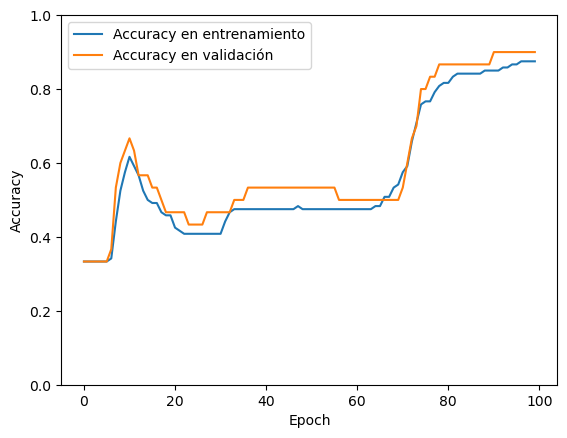

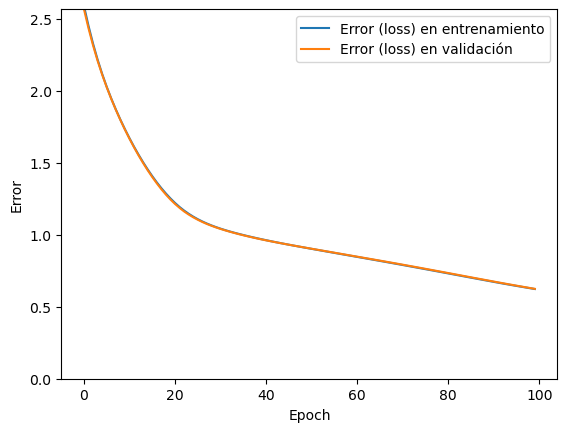

In [268]:
# # Creamos una instancia del modelo
# network = baseline_model()

# # Entrenamos el modelo
# history = network.fit(
#     X_train, train_labels,
#     epochs=100,
#     batch_size=5,
#     validation_data=(X_val, val_labels),
#     shuffle=True
# )

# Mostramos la gráfica de entrenamiento
plot_history(history)
print("Máximo error:",max(np.array(history.history['loss'])))
print("Mínimo error:",min(np.array(history.history['loss'])))


## Evaluación del modelo

Comenzaremos calculando la tasa de acierto y el loss sobre el conjunto de test, para posteriormente mostrar la matriz de confusión.

In [269]:
# Calculamos la tasa de acierto sobre el conjunto de test
test_loss, test_acc = model.evaluate(X_test, test_labels)
print('Test Accuracy: ', test_acc, '\nTest Loss: ', test_loss)

# Devolvemos directamente la clase con el valor de predicción más alto
y_pred = np.argmax(model.predict(X_test), axis=-1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9000 - loss: 0.6240
Test Accuracy:  0.8999999761581421 
Test Loss:  0.6240318417549133
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


In [270]:
# Podemos ver el array de predicciones
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2], dtype=int64)

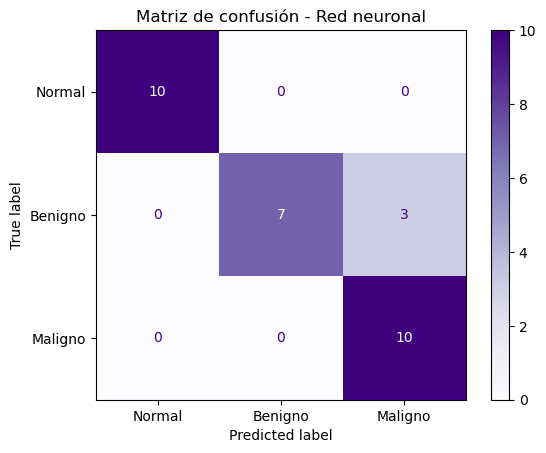

In [271]:
# Mostramos la matriz de confusión
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap="Purples")
plt.title("Matriz de confusión - Red neuronal")
plt.show()

In [272]:
# Mostramos las métricas asociadas a la matriz de confusión
print(classification_report(y_test, y_pred, target_names=classes))

              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00        10
     Benigno       1.00      0.70      0.82        10
     Maligno       0.77      1.00      0.87        10

    accuracy                           0.90        30
   macro avg       0.92      0.90      0.90        30
weighted avg       0.92      0.90      0.90        30



# Entregables

A partir del contenido de este Notebook se desarrollarán dos prácticas, una para la parte teórica (Sistemas de Aprendizaje Automático) y otra para la práctica (Programación de Inteligencia Artificial). La baremación de las mismas esta constituida por las diferentes partes que las conforman:
1. Práctica: parte teórica (Sistemas de aprendizaje automático):
    * Primera parte: evaluación multiclase (3ptos).
    * Quinta parte: documentación (7ptos).

2. Práctica: parte de código (Programación de Inteligencia Artificial):
    * Segunda parte: validación (3ptos)
    * Tercera parte: investigación de modelos supervisados (4ptos)
    * Cuarta parte: comparativa de modelos (3ptos)

Los enunciados de cada una de las partes aparecen a continuación. Se recomienda desarrollar las prácticas en el orden en el que aparecen cada una de las partes.

### **Primera parte: evaluación multiclase** (Parte teórica - 3ptos)
Calcula, de manera manual, detallada y reflejando los diferentes pasos, las métricas de accuracy, precision, recall y F1-score para cada una de las tres clases. Utiliza los resultados de las dos celdas previas para comprobar que los cálculos realizados son correctos. Al ejecutar por primera vez la libreta al completo, obtenemos:

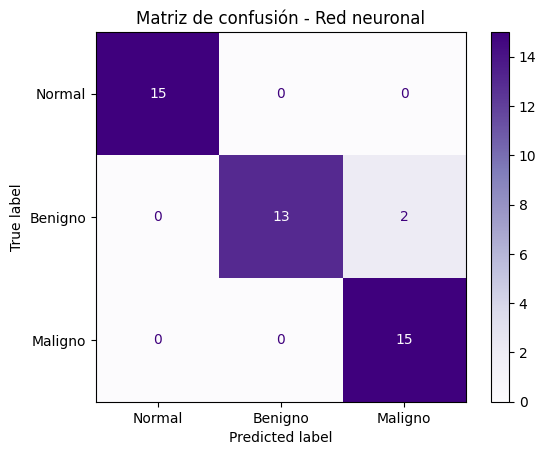

              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00        15
     Benigno       1.00      0.87      0.93        15
     Maligno       0.88      1.00      0.94        15

    accuracy                            0.96        45
    macro avg       0.96      0.96      0.96        45
    weighted avg    0.96      0.96      0.96        45

Puedes utilizar el artículo del aula virtual (en Sistemas de Aprendizaje Automático) para comprobar qué celdas de la matriz hay que tener en cuenta para cada clase. **Es obligatorio** representar graficamente las celdas afectadas para los cálculos de cada clase.

### **Segunda parte: validación** (Parte de código - 3ptos)
Revisando la celda en la que se entrena el modelo, vemos que hay un error. **¿Qué problema se está produciendo?**

Soluciónalo con una nueva partición de validación. Hay dos opciones:
- Aplicar validación simple: es la opción más sencilla y sólo tendremos que volver a dividir el conjunto de entrenamiento en dos. Recuerda traducir las etiquetas de las clases para el conjunto de validación, tal y como se hace ya en la libreta para *training* y *test*. Realizar esta modificación sólo aporta **0,75/3** sobre la calificación total del apartado.

- Aplicar validación cruzada: esta opción es la realmente óptima para nuestro problema, debido, entre otras cuestiones, a que tenemos un conjunto de datos muy pequeño. Sin embargo, es la más compleja, y por lo tanto implementar esta modificación correctamente hace que optemos a la máxima nota para este apartado **(2/2)**. Hay dos formas de implementarla en este caso:
  * Con StratifiedKFold (de Scikit): este método puede parecer la solución más directa, y de hecho lo es si trabajamos con modelos de Scikit, pero al usar un modelo hecho con Keras tendremos que realizar algunas conversiones de datos. Esta forma puede no ser demasiado intuitiva cuando comenzamos a trabajar con modelos de Machine Learning, pero puede realizarse. Para más información sobre los formatos de etiquetas, consulta el [Anexo](#anexo) de esta libreta.

  * Creando nuestro propio algoritmo: puedes ver los diferentes pasos que lo componen en el archivo "implementacion_cv_keras.pdf" que aparece en el Aula Virtual (en Programación de Inteligencia Artificial).

**Importante**: en el caso de implementar la validación cruzada, hay que entrenar al final del proceso un nuevo modelo (modelo final) usando todos los datos de entrenamiento, por lo que no usaremos nada relacionado con el hiperparámetro "validation_data". Este modelo será el que pondremos a prueba con el conjuto de *test* (apartado de validación). Para mostrar la gráfica en este punto, tenemos que tener en cuenta que sólo tenemos disponibles los resultados del entrenamiento, así que tendremos que modificar su función correspondiente para que se pueda ejecutar sin problema alguno.

### **Tercera parte: investigación de modelos supervisados** (Parte de código - 4ptos)

Define y entrena un modelo de ML (para problemas de clasificación), con el fin de compararlo posteriormente con nuestra red neuronal. Se puede elegir cualquiera de los que incluye scikit, pero será necesario que expliquéis su funcionamiento con vuestras propias palabras.

En principio, los algoritmos disponibles son los siguientes (aunque tendréis que aseguraros de que el algoritmo elegido realmente se puede utilizar en este problema):



````
from sklearn.tree import ExtraTreeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm.classes import OneClassSVM
from sklearn.neural_network.multilayer_perceptron import MLPClassifier
from sklearn.neighbors.classification import RadiusNeighborsClassifier
from sklearn.neighbors.classification import KNeighborsClassifier
from sklearn.multioutput import ClassifierChain
from sklearn.multioutput import MultiOutputClassifier
from sklearn.multiclass import OutputCodeClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model.stochastic_gradient import SGDClassifier
from sklearn.linear_model.ridge import RidgeClassifierCV
from sklearn.linear_model.ridge import RidgeClassifier
from sklearn.linear_model.passive_aggressive import PassiveAggressiveClassifier    
from sklearn.gaussian_process.gpc import GaussianProcessClassifier
from sklearn.ensemble.voting_classifier import VotingClassifier
from sklearn.ensemble.weight_boosting import AdaBoostClassifier
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from sklearn.ensemble.bagging import BaggingClassifier
from sklearn.ensemble.forest import ExtraTreesClassifier
from sklearn.ensemble.forest import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import GaussianNB
from sklearn.semi_supervised import LabelPropagation
from sklearn.semi_supervised import LabelSpreading
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.naive_bayes import MultinomialNB  
from sklearn.neighbors import NearestCentroid
from sklearn.svm import NuSVC
from sklearn.linear_model import Perceptron
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.mixture import DPGMM
from sklearn.mixture import GMM
from sklearn.mixture import GaussianMixture
from sklearn.mixture import VBGMM
````

Otra opción es definir una nueva red neuronal, pero en el caso de hacerlo la estructura tendrá que ser algo más "creativa" y no valdrá simplemente con modificar los parámetros de la que hay actualmente. En el caso de presentar una nueva red simple como la que hay ahora mismo en el Notebook, el apartado puntuará unicamente **1/4**, por lo que la calificación máxima a conseguir dentro de la prácitica será de **7/10**.

En general, en este apartado se valorará principalmente la creatividad y/o el uso de algoritmos que no han sido explicados en clase. Además de la claridad y el detalle en las explicaciones de la solución propuesta. **La puntuación que obtenga el nuevo modelo en validación y en test es algo anecdótico** (ya que estamos utilizando un conjunto de datos demasiado simple).

### **Cuarta parte: comparativa de modelos** (Parte de código - 3ptos)

Habiendo entrenado los dos modelos, se evaluarán utilizando los recursos creados en el ejercicio de evaluación de modelos. Éstos nos servirán para evaluar de manera individual cada una de las soluciones propuestas, y posteriormente compararlas. Se valorará la claridad, detalle y desarrollo del apartado.

### **Quinta parte: documentación** (Parte teórica - 7ptos)

Se creará una pequeña guía sobre el funcionamiento y uso del algoritmo utilizado, preferiblemente en formato *Markdown*, para ser expuesta en un repositorio de GitHub. **Las ideas principales de dicha guía se expondrán posteriormente en una clase**. La forma de dicha sesión está por determinar, pero los contenidos a exponer (que tendrán que estar reflejados en la guía) deben centrarse en:

*   Funcionamiento del algoritmo
*   Consideraciones/detalles a tener en cuenta a la hora de implementarlo (por ejemplo, problemas que puedan surgir).



<a name="anexo"></a>
# Anexo: codificaciones de etiquetas en Scikit y Keras

### Codificación utilizada por Scikit-Learn (StratifiedKFold)

Se llama Label Encoding (o Integer Encoding), y podríamos decir que es como un "catálogo". A cada clase le asignamos un número único.
* Formato: Un array de 1 dimensión.
* Ejemplo:
    * Benigno = 0
    * Maligno = 1
    * Normal = 2
* Dato: [0, 1, 2, 0]

Scikit-Learn prefiere esto porque es eficiente en memoria (solo un número por fila) y sus algoritmos (como los árboles de decisión o SVM) están programados para trabajar internamente con clases discretas.

### Codificación utilizada por Keras

Se llama One-Hot Encoding, y funciona como un panel de interruptores. Tienes tantos interruptores (neuronas) como clases. Solo uno puede estar encendido (1) a la vez.
* Formato: una matriz de 2 dimensiones (N muestras x 3 clases).
* Ejemplo:
    * Benigno (Clase 0) → El interruptor 0 está ON: [1, 0, 0]
    * Maligno (Clase 1) → El interruptor 1 está ON: [0, 1, 0]
    * Normal (Clase 2) → El interruptor 2 está ON: [0, 0, 1]
* Dato: [[1,0,0], [0,1,0], [0,0,1], [1,0,0]]

Keras utiliza esta codificación porque es más cómodo en redes neuronales. La capa final tiene 3 neuronas físicas, y para calcular el error, la red compara la probabilidad que "saca" la neurona 1 con el valor real (1 o 0), la neurona 2 con su valor, y así sucesivamente. Necesita ese formato desagregado para las matemáticas que definen el proceso de retropropagación (backpropagation), el cual es el encargado de actualizar los pesos.